# 11 - Maintainer Tools: VSM Dashboard, Policy Recommendations & CI/CD Templates

Practical tools for OSS project maintainers to improve governance health:

1. **VSM Health Dashboard** - Visual report card showing S1-S5 subsystem health
2. **Automated S5 Policy Recommendations** - Generated governance file suggestions
3. **CI/CD Templates** - Ready-to-use configs to improve S2 (Coordination) scores

These tools bridge the gap between academic analysis and actionable improvements.

In [1]:
import json
import sys
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Any, Optional
from dataclasses import dataclass, field
from textwrap import dedent

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import seaborn as sns

# Add src to path
sys.path.insert(0, '..')
from src.analysis.entropy_calculation import EntropyCalculator
from data.candidates import ALL_CANDIDATES

# Build category lookup
category_lookup = {}
for category, repos in ALL_CANDIDATES.items():
    for repo in repos:
        category_lookup[repo.lower()] = category

plt.rcParams['text.usetex'] = False
print("Setup complete!")

Setup complete!


In [2]:
# Load project data
data_dir = Path("../data/raw")
projects = {}

for file_path in data_dir.glob("*_data.json"):
    with open(file_path, 'r') as f:
        data = json.load(f)
        repo_info = data.get('repository', {})
        if 'error' in repo_info or 'full_name' not in repo_info:
            continue
        repo_name = repo_info['full_name']
        data['_category'] = category_lookup.get(repo_name.lower(), 'unknown')
        projects[repo_name] = data

print(f"Loaded {len(projects)} projects")

Loaded 94 projects


---
## 1. VSM Health Dashboard

A comprehensive visual report card showing:
- S1-S5 subsystem scores with traffic light indicators
- Radar chart of VSM profile
- Comparison to category benchmarks
- Priority improvement areas
- Historical trend (if available)

In [3]:
@dataclass
class VSMSubsystemScore:
    """Score for a single VSM subsystem."""
    name: str
    score: float  # 0-100
    indicators: Dict[str, Any] = field(default_factory=dict)
    recommendations: List[str] = field(default_factory=list)
    
    @property
    def status(self) -> str:
        if self.score >= 70:
            return 'healthy'
        elif self.score >= 40:
            return 'warning'
        else:
            return 'critical'
    
    @property
    def color(self) -> str:
        return {'healthy': '#2ecc71', 'warning': '#f39c12', 'critical': '#e74c3c'}[self.status]


@dataclass
class VSMHealthReport:
    """Complete VSM health report for a project."""
    repository: str
    category: str
    generated_at: str
    subsystems: Dict[str, VSMSubsystemScore] = field(default_factory=dict)
    overall_score: float = 0.0
    risk_level: str = 'unknown'
    priority_actions: List[str] = field(default_factory=list)
    
    def to_dict(self) -> dict:
        return {
            'repository': self.repository,
            'category': self.category,
            'generated_at': self.generated_at,
            'overall_score': self.overall_score,
            'risk_level': self.risk_level,
            'subsystems': {k: {'score': v.score, 'status': v.status} for k, v in self.subsystems.items()},
            'priority_actions': self.priority_actions
        }

In [4]:
class VSMHealthDashboard:
    """
    Generate VSM Health Dashboard for OSS projects.
    
    Maps project metrics to Beer's Viable System Model:
    - S1 (Operations): Primary activities, contributor engagement
    - S2 (Coordination): Anti-oscillation, code review processes
    - S3 (Control): Internal regulation, maintainer oversight
    - S3* (Audit): Sporadic monitoring, CI/CD checks
    - S4 (Intelligence): Environment scanning, community engagement
    - S5 (Policy): Identity, governance, strategic direction
    """
    
    def __init__(self):
        self.entropy_calc = EntropyCalculator()
        
        # Category benchmarks (from our analysis)
        self.benchmarks = {
            'federation': {'S1': 75, 'S2': 60, 'S3': 70, 'S4': 55, 'S5': 65},
            'club': {'S1': 65, 'S2': 45, 'S3': 55, 'S4': 45, 'S5': 45},
            'stadium': {'S1': 55, 'S2': 35, 'S3': 40, 'S4': 40, 'S5': 30},
            'toy': {'S1': 30, 'S2': 20, 'S3': 25, 'S4': 30, 'S5': 15},
        }
    
    def analyze_s1_operations(self, project_data: dict) -> VSMSubsystemScore:
        """S1: Operations - Primary activities and contributor engagement."""
        contributors = project_data.get('contributors', [])
        commits = project_data.get('recent_commits', [])
        prs = project_data.get('pull_requests', {}).get('pull_requests', [])
        
        # Indicators
        contributor_count = len(contributors)
        commit_count = len(commits)
        pr_count = len(prs)
        
        # Calculate bus factor
        if contributors:
            contributions = sorted([c.get('contributions', 0) for c in contributors], reverse=True)
            total = sum(contributions)
            cumsum = 0
            bus_factor = 0
            for c in contributions:
                cumsum += c
                bus_factor += 1
                if cumsum >= total * 0.5:
                    break
        else:
            bus_factor = 0
        
        # Score calculation
        score = 0
        score += min(30, contributor_count * 0.5)  # Up to 30 points for contributors
        score += min(25, commit_count * 0.5)       # Up to 25 points for commits
        score += min(25, pr_count * 0.5)           # Up to 25 points for PRs
        score += min(20, bus_factor * 5)           # Up to 20 points for bus factor
        
        recommendations = []
        if bus_factor <= 1:
            recommendations.append("CRITICAL: Bus factor is 1 - identify and mentor backup maintainers")
        if contributor_count < 10:
            recommendations.append("Expand contributor base through good-first-issues and documentation")
        if commit_count < 20:
            recommendations.append("Activity appears low - consider project promotion or community outreach")
        
        return VSMSubsystemScore(
            name='S1: Operations',
            score=min(100, score),
            indicators={
                'contributors': contributor_count,
                'commits_recent': commit_count,
                'pull_requests': pr_count,
                'bus_factor': bus_factor
            },
            recommendations=recommendations
        )
    
    def analyze_s2_coordination(self, project_data: dict) -> VSMSubsystemScore:
        """S2: Coordination - Anti-oscillation, review processes."""
        gov_files = project_data.get('governance_files', {})
        prs = project_data.get('pull_requests', {})
        pr_stats = prs.get('statistics', {})
        pr_list = prs.get('pull_requests', [])
        
        # Indicators
        has_codeowners = bool(gov_files.get('.github/CODEOWNERS'))
        avg_merge_time = pr_stats.get('avg_time_to_merge', 0)
        
        # Review rate
        if pr_list:
            reviewed_prs = sum(1 for pr in pr_list if pr.get('review_count', 0) > 0)
            review_rate = reviewed_prs / len(pr_list)
        else:
            review_rate = 0
        
        # Score calculation
        score = 0
        score += 30 if has_codeowners else 0
        score += review_rate * 40  # Up to 40 points for review coverage
        
        # Merge time scoring (moderate time = good process)
        if 24 <= avg_merge_time <= 168:  # 1-7 days
            score += 30
        elif avg_merge_time > 0:
            score += 15
        
        recommendations = []
        if not has_codeowners:
            recommendations.append("Add CODEOWNERS file to auto-assign reviewers")
        if review_rate < 0.5:
            recommendations.append("Increase PR review coverage - consider required reviews")
        if avg_merge_time > 336:  # > 2 weeks
            recommendations.append("PRs taking too long to merge - review bottlenecks")
        
        return VSMSubsystemScore(
            name='S2: Coordination',
            score=min(100, score),
            indicators={
                'has_codeowners': has_codeowners,
                'review_rate': f"{review_rate:.0%}",
                'avg_merge_time_hrs': round(avg_merge_time, 1)
            },
            recommendations=recommendations
        )
    
    def analyze_s3_control(self, project_data: dict) -> VSMSubsystemScore:
        """S3: Control - Internal regulation and maintainer oversight."""
        gov_files = project_data.get('governance_files', {})
        maintainers = project_data.get('maintainers', {}).get('statistics', {})
        
        # Indicators
        has_contributing = bool(gov_files.get('CONTRIBUTING.md'))
        has_maintainers = bool(gov_files.get('MAINTAINERS.md'))
        active_maintainers = maintainers.get('active_maintainers_6mo', 0)
        
        # Score calculation
        score = 0
        score += 25 if has_contributing else 0
        score += 25 if has_maintainers else 0
        score += min(50, active_maintainers * 12.5)  # Up to 50 points for maintainers
        
        recommendations = []
        if not has_contributing:
            recommendations.append("Add CONTRIBUTING.md with clear contribution guidelines")
        if not has_maintainers:
            recommendations.append("Document maintainer roles in MAINTAINERS.md")
        if active_maintainers <= 1:
            recommendations.append("Single maintainer risk - develop succession plan")
        
        return VSMSubsystemScore(
            name='S3: Control',
            score=min(100, score),
            indicators={
                'has_contributing': has_contributing,
                'has_maintainers_file': has_maintainers,
                'active_maintainers': active_maintainers
            },
            recommendations=recommendations
        )
    
    def analyze_s4_intelligence(self, project_data: dict) -> VSMSubsystemScore:
        """S4: Intelligence - Environment scanning and community engagement."""
        repo = project_data.get('repository', {})
        gov_files = project_data.get('governance_files', {})
        issues = project_data.get('issues', {}).get('statistics', {})
        
        # Indicators
        has_discussions = repo.get('has_discussions', False)
        has_roadmap = bool(gov_files.get('ROADMAP.md'))
        avg_issue_close = issues.get('avg_time_to_close', 0)
        
        # Score calculation
        score = 0
        score += 30 if has_discussions else 0
        score += 30 if has_roadmap else 0
        
        # Issue responsiveness
        if avg_issue_close > 0:
            if avg_issue_close < 72:  # < 3 days
                score += 40
            elif avg_issue_close < 168:  # < 1 week
                score += 30
            elif avg_issue_close < 720:  # < 1 month
                score += 20
            else:
                score += 10
        
        recommendations = []
        if not has_discussions:
            recommendations.append("Enable GitHub Discussions for community engagement")
        if not has_roadmap:
            recommendations.append("Create ROADMAP.md to communicate project direction")
        if avg_issue_close > 720:
            recommendations.append("Improve issue response time - consider triage process")
        
        return VSMSubsystemScore(
            name='S4: Intelligence',
            score=min(100, score),
            indicators={
                'has_discussions': has_discussions,
                'has_roadmap': has_roadmap,
                'avg_issue_close_hrs': round(avg_issue_close, 1)
            },
            recommendations=recommendations
        )
    
    def analyze_s5_policy(self, project_data: dict) -> VSMSubsystemScore:
        """S5: Policy - Identity, governance, and strategic direction."""
        repo = project_data.get('repository', {})
        gov_files = project_data.get('governance_files', {})
        
        # Indicators
        has_governance = bool(gov_files.get('GOVERNANCE.md'))
        has_coc = bool(gov_files.get('CODE_OF_CONDUCT.md'))
        
        license_info = repo.get('license')
        if license_info is None:
            has_license = False
            license_name = 'None'
        elif isinstance(license_info, str):
            has_license = True
            license_name = license_info
        else:
            has_license = True
            license_name = license_info.get('name', 'Unknown')
        
        has_description = bool(repo.get('description'))
        
        # Foundation backing check
        owner = repo.get('owner', {}).get('login', '')
        foundation_owners = ['apache', 'linux', 'cncf', 'eclipse', 'openstack', 'python', 'nodejs', 'rust-lang']
        is_foundation = any(fo in owner.lower() for fo in foundation_owners)
        
        # Score calculation
        score = 0
        score += 30 if has_governance else 0
        score += 20 if has_coc else 0
        score += 20 if has_license else 0
        score += 10 if has_description else 0
        score += 20 if is_foundation else 0
        
        recommendations = []
        if not has_governance:
            recommendations.append("Add GOVERNANCE.md documenting decision-making processes")
        if not has_coc:
            recommendations.append("Add CODE_OF_CONDUCT.md to set community expectations")
        if not has_license:
            recommendations.append("Add an OSI-approved license to clarify usage rights")
        
        return VSMSubsystemScore(
            name='S5: Policy',
            score=min(100, score),
            indicators={
                'has_governance': has_governance,
                'has_code_of_conduct': has_coc,
                'license': license_name,
                'is_foundation_backed': is_foundation
            },
            recommendations=recommendations
        )
    
    def generate_report(self, project_data: dict) -> VSMHealthReport:
        """Generate complete VSM health report."""
        repo_name = project_data.get('repository', {}).get('full_name', 'Unknown')
        category = project_data.get('_category', 'unknown')
        
        # Analyze all subsystems
        subsystems = {
            'S1': self.analyze_s1_operations(project_data),
            'S2': self.analyze_s2_coordination(project_data),
            'S3': self.analyze_s3_control(project_data),
            'S4': self.analyze_s4_intelligence(project_data),
            'S5': self.analyze_s5_policy(project_data),
        }
        
        # Calculate overall score (weighted)
        weights = {'S1': 0.25, 'S2': 0.20, 'S3': 0.20, 'S4': 0.15, 'S5': 0.20}
        overall = sum(subsystems[k].score * weights[k] for k in subsystems)
        
        # Determine risk level
        critical_count = sum(1 for s in subsystems.values() if s.status == 'critical')
        if critical_count >= 2 or overall < 30:
            risk_level = 'CRITICAL'
        elif critical_count >= 1 or overall < 50:
            risk_level = 'HIGH'
        elif overall < 70:
            risk_level = 'MEDIUM'
        else:
            risk_level = 'LOW'
        
        # Collect priority actions (from critical/warning subsystems)
        priority_actions = []
        for key in ['S1', 'S2', 'S3', 'S4', 'S5']:
            sub = subsystems[key]
            if sub.status in ['critical', 'warning'] and sub.recommendations:
                priority_actions.extend(sub.recommendations[:2])  # Top 2 per subsystem
        
        return VSMHealthReport(
            repository=repo_name,
            category=category,
            generated_at=datetime.now().isoformat(),
            subsystems=subsystems,
            overall_score=overall,
            risk_level=risk_level,
            priority_actions=priority_actions[:10]  # Top 10 actions
        )

# Initialize dashboard
dashboard = VSMHealthDashboard()
print("VSM Health Dashboard initialized!")

VSM Health Dashboard initialized!


In [5]:
def visualize_health_dashboard(report: VSMHealthReport, benchmarks: dict = None, save_path: str = None):
    """
    Create visual health dashboard for a project.
    """
    fig = plt.figure(figsize=(16, 12), constrained_layout=True)
    gs = GridSpec(3, 3, figure=fig, height_ratios=[1, 1.2, 0.8])
    
    # Color scheme
    status_colors = {'healthy': '#2ecc71', 'warning': '#f39c12', 'critical': '#e74c3c'}
    risk_colors = {'LOW': '#2ecc71', 'MEDIUM': '#f1c40f', 'HIGH': '#e67e22', 'CRITICAL': '#e74c3c'}
    
    # 1. Header - Overall Score and Risk Level
    ax_header = fig.add_subplot(gs[0, :])
    ax_header.axis('off')
    
    # Title
    ax_header.text(0.5, 0.85, f"VSM Health Dashboard", fontsize=24, fontweight='bold',
                   ha='center', va='top', transform=ax_header.transAxes)
    ax_header.text(0.5, 0.65, f"{report.repository}", fontsize=18,
                   ha='center', va='top', transform=ax_header.transAxes, color='#555')
    
    # Overall score gauge
    score_color = status_colors['healthy'] if report.overall_score >= 70 else (
        status_colors['warning'] if report.overall_score >= 40 else status_colors['critical'])
    ax_header.text(0.2, 0.35, f"Overall Score", fontsize=14, ha='center', transform=ax_header.transAxes)
    ax_header.text(0.2, 0.1, f"{report.overall_score:.0f}", fontsize=48, fontweight='bold',
                   ha='center', transform=ax_header.transAxes, color=score_color)
    
    # Risk level badge
    ax_header.text(0.5, 0.35, f"Risk Level", fontsize=14, ha='center', transform=ax_header.transAxes)
    risk_color = risk_colors.get(report.risk_level, 'gray')
    bbox = dict(boxstyle='round,pad=0.3', facecolor=risk_color, edgecolor='none', alpha=0.9)
    ax_header.text(0.5, 0.1, f" {report.risk_level} ", fontsize=24, fontweight='bold',
                   ha='center', transform=ax_header.transAxes, color='white', bbox=bbox)
    
    # Category badge
    ax_header.text(0.8, 0.35, f"Category", fontsize=14, ha='center', transform=ax_header.transAxes)
    ax_header.text(0.8, 0.1, f"{report.category.title()}", fontsize=24,
                   ha='center', transform=ax_header.transAxes, color='#3498db')
    
    # 2. Radar Chart - VSM Profile
    ax_radar = fig.add_subplot(gs[1, 0], polar=True)
    
    subsystem_names = ['S1', 'S2', 'S3', 'S4', 'S5']
    subsystem_labels = ['S1\nOperations', 'S2\nCoordination', 'S3\nControl', 'S4\nIntelligence', 'S5\nPolicy']
    scores = [report.subsystems[s].score for s in subsystem_names]
    
    angles = np.linspace(0, 2 * np.pi, len(subsystem_names), endpoint=False).tolist()
    scores_plot = scores + scores[:1]
    angles_plot = angles + angles[:1]
    
    ax_radar.plot(angles_plot, scores_plot, 'o-', linewidth=2, color='#3498db', markersize=8)
    ax_radar.fill(angles_plot, scores_plot, alpha=0.25, color='#3498db')
    
    # Add benchmark if available
    if benchmarks and report.category in benchmarks:
        bench = benchmarks[report.category]
        bench_scores = [bench[s] for s in subsystem_names] + [bench['S1']]
        ax_radar.plot(angles_plot, bench_scores, '--', linewidth=1.5, color='#95a5a6', label='Category Avg')
    
    ax_radar.set_xticks(angles)
    ax_radar.set_xticklabels(subsystem_labels, size=10)
    ax_radar.set_ylim(0, 100)
    ax_radar.set_title('VSM Profile', pad=20, fontsize=14, fontweight='bold')
    if benchmarks:
        ax_radar.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    
    # 3. Subsystem Score Bars
    ax_bars = fig.add_subplot(gs[1, 1])
    
    y_pos = np.arange(len(subsystem_names))
    colors = [report.subsystems[s].color for s in subsystem_names]
    
    bars = ax_bars.barh(y_pos, scores, color=colors, height=0.6)
    ax_bars.set_yticks(y_pos)
    ax_bars.set_yticklabels([f"{s}: {report.subsystems[s].name.split(': ')[1]}" for s in subsystem_names])
    ax_bars.set_xlim(0, 100)
    ax_bars.set_xlabel('Score')
    ax_bars.set_title('Subsystem Scores', fontsize=14, fontweight='bold')
    
    # Add score labels
    for bar, score in zip(bars, scores):
        ax_bars.text(score + 2, bar.get_y() + bar.get_height()/2, f'{score:.0f}',
                     va='center', fontsize=11, fontweight='bold')
    
    # Add threshold lines
    ax_bars.axvline(x=70, color='#2ecc71', linestyle='--', alpha=0.5, label='Healthy')
    ax_bars.axvline(x=40, color='#f39c12', linestyle='--', alpha=0.5, label='Warning')
    ax_bars.legend(loc='lower right', fontsize=9)
    
    # 4. Key Indicators
    ax_indicators = fig.add_subplot(gs[1, 2])
    ax_indicators.axis('off')
    
    indicator_text = "KEY INDICATORS\n" + "="*30 + "\n\n"
    for s_name in subsystem_names:
        sub = report.subsystems[s_name]
        indicator_text += f"{s_name} ({sub.status.upper()}):\n"
        for key, val in list(sub.indicators.items())[:3]:
            indicator_text += f"  - {key}: {val}\n"
        indicator_text += "\n"
    
    ax_indicators.text(0.05, 0.95, indicator_text, fontsize=10, family='monospace',
                       va='top', transform=ax_indicators.transAxes)
    
    # 5. Priority Actions
    ax_actions = fig.add_subplot(gs[2, :])
    ax_actions.axis('off')
    
    action_text = "PRIORITY ACTIONS\n" + "="*80 + "\n\n"
    for i, action in enumerate(report.priority_actions[:8], 1):
        action_text += f"{i}. {action}\n"
    
    if not report.priority_actions:
        action_text += "No critical actions required - project is healthy!\n"
    
    ax_actions.text(0.02, 0.95, action_text, fontsize=11, family='monospace',
                    va='top', transform=ax_actions.transAxes)
    
    # Footer
    fig.text(0.99, 0.01, f"Generated: {report.generated_at[:10]}", fontsize=9,
             ha='right', va='bottom', color='#888')
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='white')
        print(f"Dashboard saved to: {save_path}")
    
    plt.show()
    return fig

print("Dashboard visualization function ready!")

Dashboard visualization function ready!



VSM Health Report: curl/curl
Category: stadium
Overall Score: 47.5
Risk Level: CRITICAL

Subsystem Scores:
  S1: 60 (warning)
  S2: 30 (critical)
  S3: 50 (warning)
  S4: 70 (healthy)
  S5: 30 (critical)


Dashboard saved to: ../docs/diagrams/vsm_dashboard_curl.png


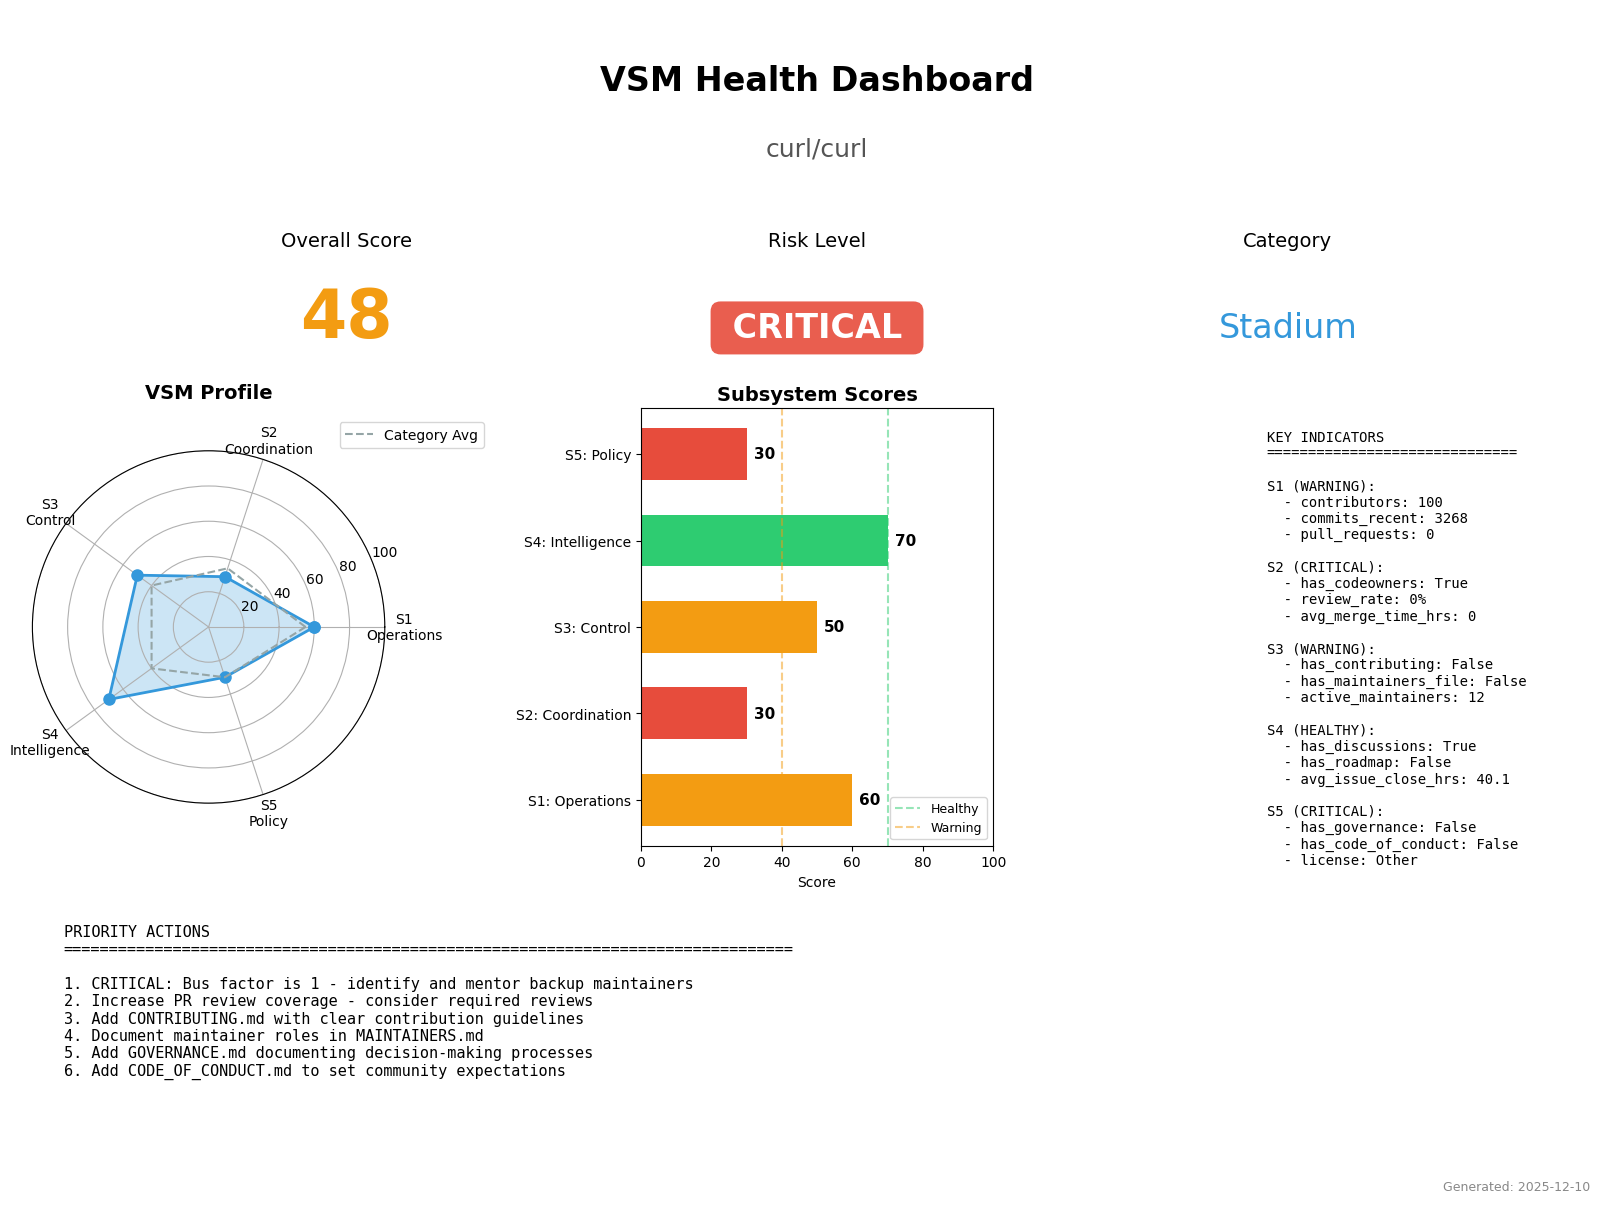

In [6]:
# Generate dashboard for a sample project
sample_project = 'curl/curl'  # Stadium example

if sample_project in projects:
    report = dashboard.generate_report(projects[sample_project])
    
    print(f"\nVSM Health Report: {report.repository}")
    print(f"Category: {report.category}")
    print(f"Overall Score: {report.overall_score:.1f}")
    print(f"Risk Level: {report.risk_level}")
    print(f"\nSubsystem Scores:")
    for key, sub in report.subsystems.items():
        print(f"  {key}: {sub.score:.0f} ({sub.status})")
    
    # Visualize
    visualize_health_dashboard(
        report, 
        benchmarks=dashboard.benchmarks,
        save_path='../docs/diagrams/vsm_dashboard_curl.png'
    )
else:
    print(f"Project {sample_project} not found")


VSM Health Report: grafana/grafana
Category: federation
Overall Score: 77.2
Risk Level: LOW


Dashboard saved to: ../docs/diagrams/vsm_dashboard_grafana.png


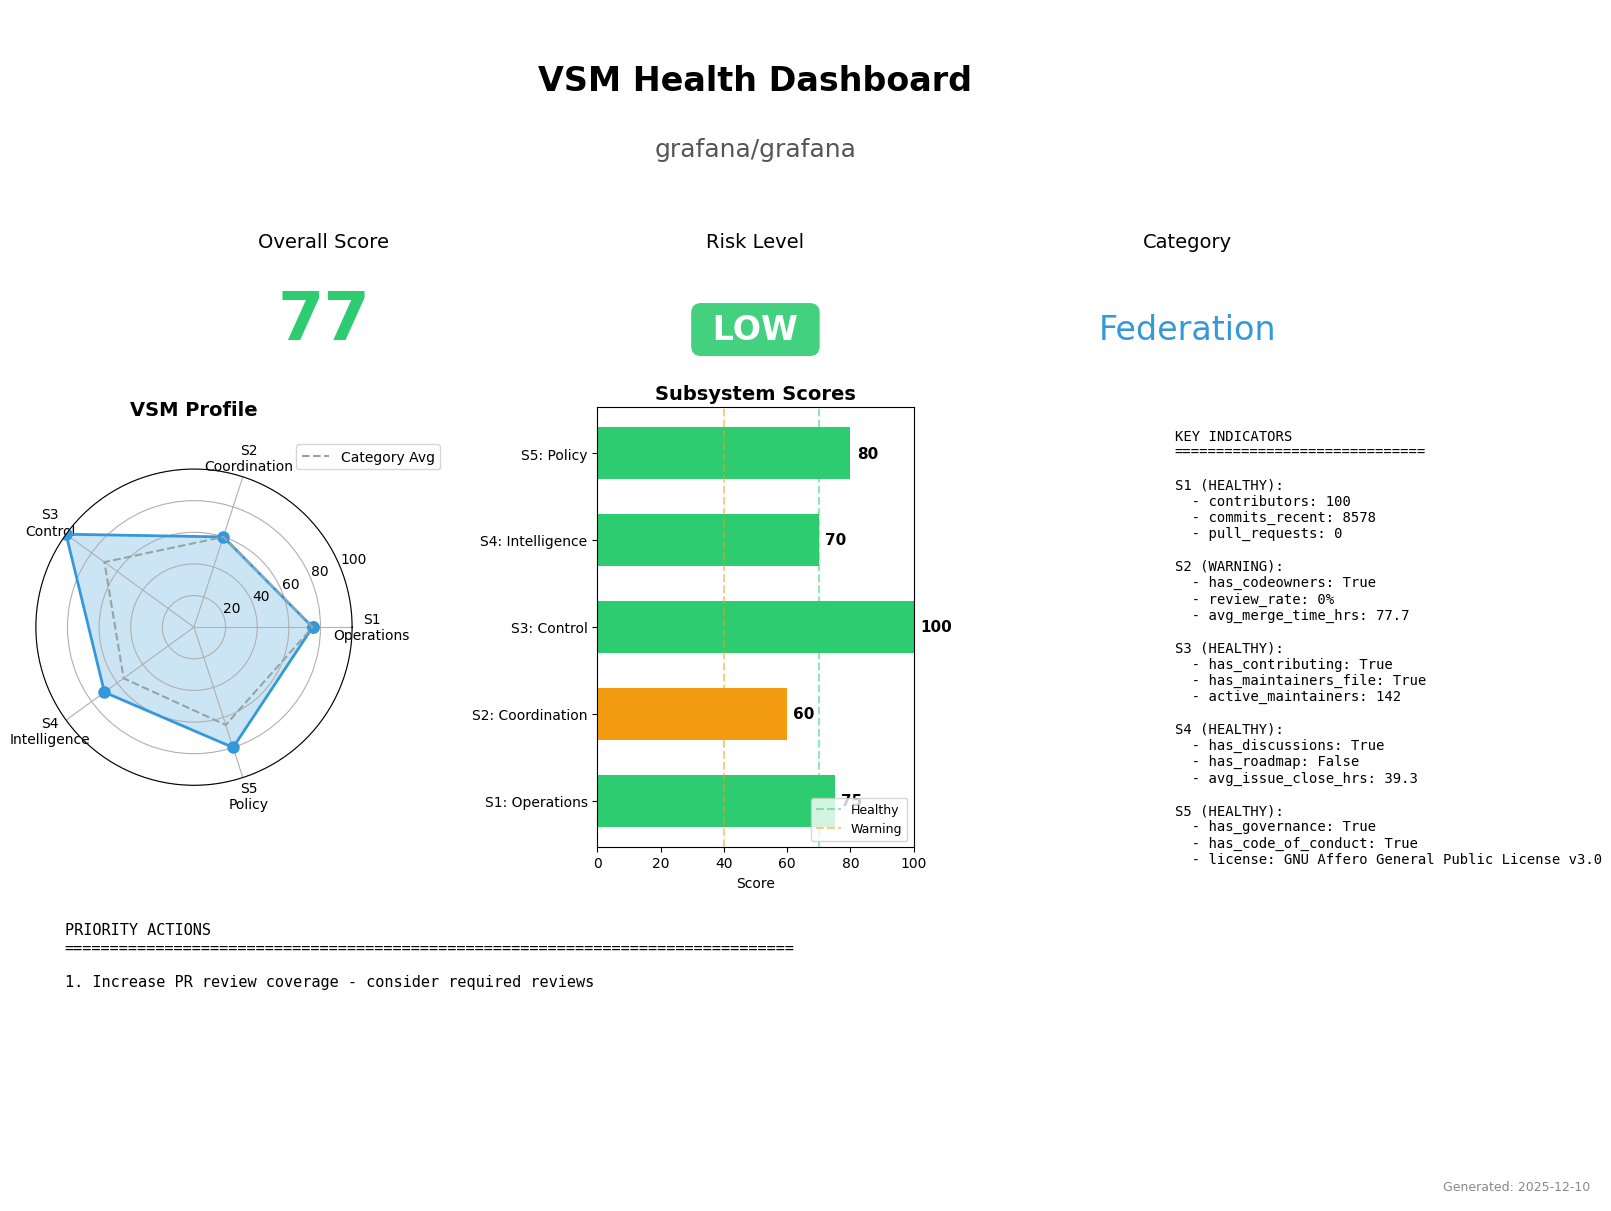

In [7]:
# Generate dashboard for a Federation project
federation_project = 'grafana/grafana'

if federation_project in projects:
    report_fed = dashboard.generate_report(projects[federation_project])
    
    print(f"\nVSM Health Report: {report_fed.repository}")
    print(f"Category: {report_fed.category}")
    print(f"Overall Score: {report_fed.overall_score:.1f}")
    print(f"Risk Level: {report_fed.risk_level}")
    
    visualize_health_dashboard(
        report_fed,
        benchmarks=dashboard.benchmarks,
        save_path='../docs/diagrams/vsm_dashboard_grafana.png'
    )


VSM Health Report: mafintosh/pump
Category: toy
Overall Score: 8.4
Risk Level: CRITICAL


Dashboard saved to: ../docs/diagrams/vsm_dashboard_toy.png


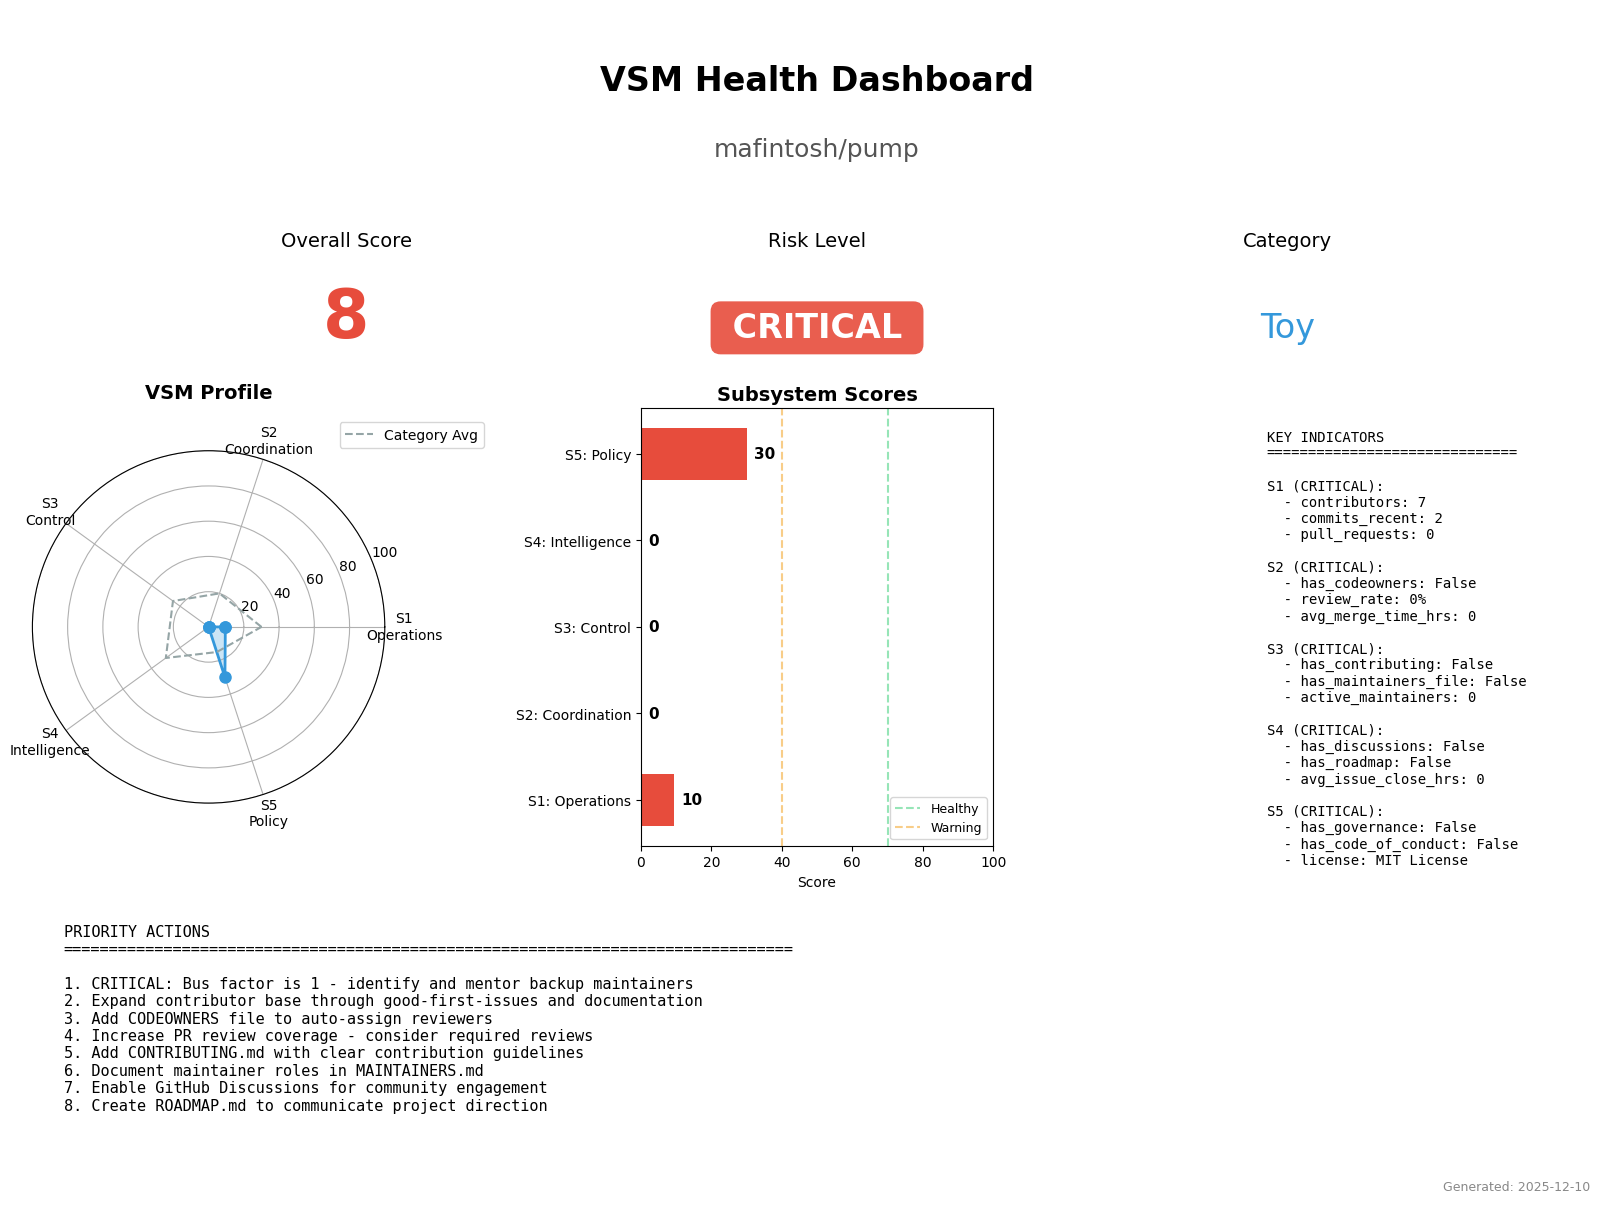

In [8]:
# Generate dashboard for a Toy project (high risk)
toy_project = 'mafintosh/pump'

if toy_project in projects:
    report_toy = dashboard.generate_report(projects[toy_project])
    
    print(f"\nVSM Health Report: {report_toy.repository}")
    print(f"Category: {report_toy.category}")
    print(f"Overall Score: {report_toy.overall_score:.1f}")
    print(f"Risk Level: {report_toy.risk_level}")
    
    visualize_health_dashboard(
        report_toy,
        benchmarks=dashboard.benchmarks,
        save_path='../docs/diagrams/vsm_dashboard_toy.png'
    )

---
## 2. Automated S5 Policy Recommendations

Generate governance file templates based on project analysis:
- GOVERNANCE.md - Decision-making processes
- CODE_OF_CONDUCT.md - Community standards
- CONTRIBUTING.md - Contribution guidelines
- MAINTAINERS.md - Maintainer roles and responsibilities

In [9]:
class PolicyRecommendationEngine:
    """
    Generate governance policy recommendations and templates.
    Tailored to project category and current health status.
    """
    
    def __init__(self):
        self.templates = self._load_templates()
    
    def _load_templates(self) -> dict:
        """Load policy templates for different categories."""
        return {
            'governance': self._governance_templates(),
            'code_of_conduct': self._coc_template(),
            'contributing': self._contributing_templates(),
            'maintainers': self._maintainers_template(),
            'codeowners': self._codeowners_template(),
        }
    
    def _governance_templates(self) -> dict:
        """Governance templates by category."""
        return {
            'toy': dedent("""
                # Governance
                
                ## Project Maintainer
                
                This project is maintained by @{owner}.
                
                ## Decision Making
                
                All decisions are made by the project maintainer. For feature requests
                or significant changes, please open an issue for discussion first.
                
                ## Contributing
                
                Contributions are welcome! Please see CONTRIBUTING.md for guidelines.
                
                ## Succession Planning
                
                If you're interested in becoming a co-maintainer, please reach out
                by opening an issue or contacting the maintainer directly.
            """).strip(),
            
            'stadium': dedent("""
                # Governance
                
                ## Roles
                
                - **Maintainer**: @{owner} - Final decision authority
                - **Contributors**: Community members who have contributed code
                - **Users**: Anyone using the project
                
                ## Decision Making
                
                1. **Minor changes**: Can be merged by maintainer after review
                2. **Major changes**: Require issue discussion before implementation
                3. **Breaking changes**: Require RFC and community feedback period
                
                ## Becoming a Maintainer
                
                Contributors who demonstrate sustained, quality contributions may be
                invited to become co-maintainers. Criteria include:
                - 10+ merged PRs
                - Participation in issue discussions
                - Alignment with project goals
                
                ## Conflict Resolution
                
                In case of disagreements, the maintainer has final say. We encourage
                respectful discussion and consensus-building where possible.
            """).strip(),
            
            'club': dedent("""
                # Governance
                
                ## Roles and Responsibilities
                
                ### Core Maintainers
                Core maintainers have commit access and are responsible for:
                - Reviewing and merging PRs
                - Triaging issues
                - Releasing new versions
                - Strategic direction
                
                ### Maintainers
                Maintainers have commit access to specific areas:
                - See CODEOWNERS for area assignments
                
                ### Contributors
                Anyone who has contributed to the project.
                
                ## Decision Making Process
                
                1. **Lazy consensus**: Silence = agreement after 72 hours
                2. **Voting**: For contentious issues, majority wins
                3. **Veto**: Core maintainers can veto with explanation
                
                ## Becoming a Maintainer
                
                1. Sustained contributions over 6+ months
                2. Nomination by existing maintainer
                3. Approval by majority of core maintainers
                
                ## Code of Conduct
                
                See CODE_OF_CONDUCT.md. Violations are handled by core maintainers.
            """).strip(),
            
            'federation': dedent("""
                # Governance
                
                ## Governance Structure
                
                ### Steering Committee
                The Steering Committee provides strategic direction and handles:
                - Major architectural decisions
                - Release planning
                - Community standards
                - Conflict resolution
                
                ### Working Groups
                Specialized groups handle specific areas:
                - **Core WG**: Runtime and APIs
                - **Docs WG**: Documentation and tutorials
                - **Security WG**: Security reviews and CVEs
                - **Community WG**: Events and outreach
                
                ### Maintainers
                See MAINTAINERS.md for the full list and responsibilities.
                
                ## Decision Making
                
                ### Technical Decisions
                1. **RFC Process**: Major changes require an RFC
                2. **Review Period**: Minimum 2 weeks for feedback
                3. **Approval**: 2+ approvals from relevant WG
                
                ### Governance Decisions
                1. Proposal to Steering Committee
                2. Community comment period (1 week)
                3. Steering Committee vote (2/3 majority)
                
                ## Becoming a Maintainer
                
                1. Significant contributions over 12+ months
                2. Nomination by Working Group
                3. Approval by Steering Committee
                
                ## Conflict Resolution
                
                1. Direct discussion between parties
                2. Mediation by uninvolved maintainer
                3. Escalation to Steering Committee
                4. Final appeal to Code of Conduct committee
            """).strip(),
        }
    
    def _coc_template(self) -> str:
        """Code of Conduct template (Contributor Covenant based)."""
        return dedent("""
            # Code of Conduct
            
            ## Our Pledge
            
            We as members, contributors, and leaders pledge to make participation in our
            community a harassment-free experience for everyone, regardless of age, body
            size, visible or invisible disability, ethnicity, sex characteristics, gender
            identity and expression, level of experience, education, socio-economic status,
            nationality, personal appearance, race, caste, color, religion, or sexual
            identity and orientation.
            
            ## Our Standards
            
            Examples of behavior that contributes to a positive environment:
            
            * Using welcoming and inclusive language
            * Being respectful of differing viewpoints and experiences
            * Gracefully accepting constructive criticism
            * Focusing on what is best for the community
            * Showing empathy towards other community members
            
            Examples of unacceptable behavior:
            
            * The use of sexualized language or imagery, and sexual attention or advances
            * Trolling, insulting or derogatory comments, and personal or political attacks
            * Public or private harassment
            * Publishing others' private information without explicit permission
            * Other conduct which could reasonably be considered inappropriate
            
            ## Enforcement Responsibilities
            
            Project maintainers are responsible for clarifying and enforcing our standards
            of acceptable behavior and will take appropriate and fair corrective action in
            response to any behavior that they deem inappropriate, threatening, offensive,
            or harmful.
            
            ## Scope
            
            This Code of Conduct applies within all community spaces, and also applies when
            an individual is officially representing the community in public spaces.
            
            ## Enforcement
            
            Instances of abusive, harassing, or otherwise unacceptable behavior may be
            reported to the project team at {contact_email}.
            
            All complaints will be reviewed and investigated promptly and fairly.
            
            ## Attribution
            
            This Code of Conduct is adapted from the [Contributor Covenant][homepage],
            version 2.1, available at
            [https://www.contributor-covenant.org/version/2/1/code_of_conduct.html][v2.1].
            
            [homepage]: https://www.contributor-covenant.org
            [v2.1]: https://www.contributor-covenant.org/version/2/1/code_of_conduct.html
        """).strip()
    
    def _contributing_templates(self) -> dict:
        """Contributing templates by category."""
        return {
            'minimal': dedent("""
                # Contributing to {project_name}
                
                Thank you for your interest in contributing!
                
                ## How to Contribute
                
                1. Fork the repository
                2. Create a feature branch (`git checkout -b feature/amazing-feature`)
                3. Make your changes
                4. Commit your changes (`git commit -m 'Add amazing feature'`)
                5. Push to the branch (`git push origin feature/amazing-feature`)
                6. Open a Pull Request
                
                ## Reporting Bugs
                
                Please open an issue with:
                - A clear description of the bug
                - Steps to reproduce
                - Expected vs actual behavior
                - Environment details
                
                ## Questions?
                
                Open an issue or reach out to the maintainer.
            """).strip(),
            
            'standard': dedent("""
                # Contributing to {project_name}
                
                We love your input! We want to make contributing as easy and transparent
                as possible.
                
                ## Development Process
                
                1. Fork the repo and create your branch from `main`
                2. If you've added code, add tests
                3. If you've changed APIs, update documentation
                4. Ensure the test suite passes
                5. Make sure your code lints
                6. Issue a pull request
                
                ## Pull Request Process
                
                1. Update the README.md with details of changes if applicable
                2. Update any relevant documentation
                3. The PR will be merged once you have approval from a maintainer
                
                ## Code Style
                
                - Follow existing code conventions
                - Write meaningful commit messages
                - Keep PRs focused - one feature/fix per PR
                
                ## Reporting Bugs
                
                Use GitHub Issues with the bug template. Include:
                - Summary and background
                - Steps to reproduce
                - Expected behavior
                - Actual behavior
                - Environment (OS, version, etc.)
                
                ## Feature Requests
                
                Open an issue describing:
                - The problem you're trying to solve
                - Your proposed solution
                - Alternatives you've considered
                
                ## License
                
                By contributing, you agree that your contributions will be licensed
                under the same license as the project.
            """).strip(),
        }
    
    def _maintainers_template(self) -> str:
        """Maintainers file template."""
        return dedent("""
            # Maintainers
            
            This document lists the maintainers of {project_name}.
            
            ## Core Maintainers
            
            Core maintainers have full commit access and are responsible for releases.
            
            | Name | GitHub | Areas |
            |------|--------|-------|
            | {owner_name} | @{owner} | All |
            
            ## Area Maintainers
            
            Area maintainers have expertise in specific parts of the codebase.
            
            | Name | GitHub | Areas |
            |------|--------|-------|
            | TBD | @username | area/feature |
            
            ## Emeritus Maintainers
            
            Emeritus maintainers have stepped back from active maintenance but
            contributed significantly to the project.
            
            | Name | GitHub | Contributions |
            |------|--------|---------------|
            
            ## Becoming a Maintainer
            
            See GOVERNANCE.md for the process to become a maintainer.
        """).strip()
    
    def _codeowners_template(self) -> str:
        """CODEOWNERS template."""
        return dedent("""
            # CODEOWNERS
            # This file defines code owners for automatic review assignment.
            # See: https://docs.github.com/en/repositories/managing-your-repositorys-settings-and-features/customizing-your-repository/about-code-owners
            
            # Default owner for everything
            * @{owner}
            
            # Documentation
            /docs/ @{owner}
            *.md @{owner}
            
            # Source code
            /src/ @{owner}
            
            # Tests
            /tests/ @{owner}
            
            # CI/CD
            /.github/ @{owner}
            
            # Add more specific owners as your team grows:
            # /src/api/ @api-team
            # /src/frontend/ @frontend-team
        """).strip()
    
    def generate_recommendations(self, project_data: dict, health_report: VSMHealthReport) -> dict:
        """
        Generate policy recommendations based on project analysis.
        """
        repo = project_data.get('repository', {})
        gov_files = project_data.get('governance_files', {})
        category = project_data.get('_category', 'stadium')
        
        owner = repo.get('owner', {}).get('login', 'maintainer')
        project_name = repo.get('name', 'project')
        full_name = repo.get('full_name', f'{owner}/{project_name}')
        
        recommendations = {
            'summary': [],
            'files': {}
        }
        
        # Check S5 score and missing files
        s5_score = health_report.subsystems['S5'].score
        
        # GOVERNANCE.md
        if not gov_files.get('GOVERNANCE.md'):
            template = self.templates['governance'].get(category, self.templates['governance']['stadium'])
            recommendations['files']['GOVERNANCE.md'] = template.format(
                owner=owner,
                project_name=project_name
            )
            recommendations['summary'].append("Add GOVERNANCE.md to document decision-making processes")
        
        # CODE_OF_CONDUCT.md
        if not gov_files.get('CODE_OF_CONDUCT.md'):
            recommendations['files']['CODE_OF_CONDUCT.md'] = self.templates['code_of_conduct'].format(
                contact_email=f"{owner}@users.noreply.github.com"
            )
            recommendations['summary'].append("Add CODE_OF_CONDUCT.md to set community expectations")
        
        # CONTRIBUTING.md
        if not gov_files.get('CONTRIBUTING.md'):
            template_type = 'minimal' if category == 'toy' else 'standard'
            recommendations['files']['CONTRIBUTING.md'] = self.templates['contributing'][template_type].format(
                project_name=project_name
            )
            recommendations['summary'].append("Add CONTRIBUTING.md with contribution guidelines")
        
        # MAINTAINERS.md (for club/federation)
        if category in ['club', 'federation'] and not gov_files.get('MAINTAINERS.md'):
            recommendations['files']['MAINTAINERS.md'] = self.templates['maintainers'].format(
                project_name=project_name,
                owner=owner,
                owner_name=owner.title()
            )
            recommendations['summary'].append("Add MAINTAINERS.md to document maintainer roles")
        
        # CODEOWNERS
        if not gov_files.get('.github/CODEOWNERS'):
            recommendations['files']['.github/CODEOWNERS'] = self.templates['codeowners'].format(
                owner=owner
            )
            recommendations['summary'].append("Add CODEOWNERS for automatic review assignment")
        
        return recommendations

# Initialize policy engine
policy_engine = PolicyRecommendationEngine()
print("Policy Recommendation Engine initialized!")

Policy Recommendation Engine initialized!


In [10]:
# Generate policy recommendations for a project
test_project = 'mafintosh/pump'  # Toy project with governance gaps

if test_project in projects:
    # First get health report
    test_report = dashboard.generate_report(projects[test_project])
    
    # Generate recommendations
    recommendations = policy_engine.generate_recommendations(
        projects[test_project],
        test_report
    )
    
    print(f"\n{'='*70}")
    print(f"POLICY RECOMMENDATIONS FOR {test_project}")
    print(f"{'='*70}")
    print(f"\nCategory: {test_report.category}")
    print(f"S5 (Policy) Score: {test_report.subsystems['S5'].score:.0f}")
    
    print(f"\n{'='*70}")
    print("RECOMMENDED FILES TO ADD:")
    print(f"{'='*70}")
    
    for summary in recommendations['summary']:
        print(f"  - {summary}")
    
    print(f"\n{'='*70}")
    print("GOVERNANCE.md TEMPLATE:")
    print(f"{'='*70}")
    if 'GOVERNANCE.md' in recommendations['files']:
        print(recommendations['files']['GOVERNANCE.md'])


POLICY RECOMMENDATIONS FOR mafintosh/pump

Category: toy
S5 (Policy) Score: 30

RECOMMENDED FILES TO ADD:
  - Add GOVERNANCE.md to document decision-making processes
  - Add CODE_OF_CONDUCT.md to set community expectations
  - Add CONTRIBUTING.md with contribution guidelines
  - Add CODEOWNERS for automatic review assignment

GOVERNANCE.md TEMPLATE:
# Governance

## Project Maintainer

This project is maintained by @maintainer.

## Decision Making

All decisions are made by the project maintainer. For feature requests
or significant changes, please open an issue for discussion first.

## Contributing

Contributions are welcome! Please see CONTRIBUTING.md for guidelines.

## Succession Planning

If you're interested in becoming a co-maintainer, please reach out
by opening an issue or contacting the maintainer directly.


In [11]:
# Show CODEOWNERS template
if 'test_project' in dir() and test_project in projects:
    print(f"\n{'='*70}")
    print("CODEOWNERS TEMPLATE:")
    print(f"{'='*70}")
    if '.github/CODEOWNERS' in recommendations['files']:
        print(recommendations['files']['.github/CODEOWNERS'])


CODEOWNERS TEMPLATE:
# CODEOWNERS
# This file defines code owners for automatic review assignment.
# See: https://docs.github.com/en/repositories/managing-your-repositorys-settings-and-features/customizing-your-repository/about-code-owners

# Default owner for everything
* @maintainer

# Documentation
/docs/ @maintainer
*.md @maintainer

# Source code
/src/ @maintainer

# Tests
/tests/ @maintainer

# CI/CD
/.github/ @maintainer

# Add more specific owners as your team grows:
# /src/api/ @api-team
# /src/frontend/ @frontend-team


---
## 3. CI/CD Templates to Improve S2 Scores

Ready-to-use GitHub Actions workflows that improve coordination (S2):
- PR validation and labeling
- Automated code review assignment
- Stale issue/PR management
- Release automation

In [12]:
class CICDTemplateGenerator:
    """
    Generate CI/CD templates to improve S2 (Coordination) scores.
    """
    
    def __init__(self):
        self.templates = self._load_templates()
    
    def _load_templates(self) -> dict:
        """Load CI/CD workflow templates."""
        return {
            'pr_validation': self._pr_validation_workflow(),
            'auto_labeler': self._auto_labeler_workflow(),
            'stale_management': self._stale_workflow(),
            'release': self._release_workflow(),
            'pr_template': self._pr_template(),
            'issue_templates': self._issue_templates(),
        }
    
    def _pr_validation_workflow(self) -> str:
        """PR validation workflow."""
        return dedent("""
            # .github/workflows/pr-validation.yml
            # Validates PRs meet minimum requirements
            
            name: PR Validation
            
            on:
              pull_request:
                types: [opened, edited, synchronize]
            
            jobs:
              validate:
                runs-on: ubuntu-latest
                steps:
                  - name: Check PR title
                    uses: amannn/action-semantic-pull-request@v5
                    env:
                      GITHUB_TOKEN: ${{ secrets.GITHUB_TOKEN }}
                    with:
                      types: |
                        feat
                        fix
                        docs
                        style
                        refactor
                        perf
                        test
                        build
                        ci
                        chore
                      requireScope: false
                  
                  - name: Check PR description
                    uses: actions/github-script@v7
                    with:
                      script: |
                        const pr = context.payload.pull_request;
                        if (!pr.body || pr.body.length < 50) {
                          core.setFailed('PR description must be at least 50 characters');
                        }
            
              size-label:
                runs-on: ubuntu-latest
                steps:
                  - name: Label PR by size
                    uses: codelytv/pr-size-labeler@v1
                    with:
                      GITHUB_TOKEN: ${{ secrets.GITHUB_TOKEN }}
                      xs_label: 'size/XS'
                      xs_max_size: 10
                      s_label: 'size/S'
                      s_max_size: 100
                      m_label: 'size/M'
                      m_max_size: 500
                      l_label: 'size/L'
                      l_max_size: 1000
                      xl_label: 'size/XL'
        """).strip()
    
    def _auto_labeler_workflow(self) -> str:
        """Auto-labeler workflow based on paths."""
        return dedent("""
            # .github/workflows/auto-labeler.yml
            # Automatically labels PRs based on changed files
            
            name: Auto Labeler
            
            on:
              pull_request:
                types: [opened, synchronize]
            
            jobs:
              label:
                runs-on: ubuntu-latest
                permissions:
                  contents: read
                  pull-requests: write
                steps:
                  - uses: actions/labeler@v5
                    with:
                      repo-token: ${{ secrets.GITHUB_TOKEN }}
            
            # Also create .github/labeler.yml:
            # ---
            # documentation:
            #   - changed-files:
            #     - any-glob-to-any-file: ['docs/**', '*.md']
            # 
            # source:
            #   - changed-files:
            #     - any-glob-to-any-file: 'src/**'
            # 
            # tests:
            #   - changed-files:
            #     - any-glob-to-any-file: ['tests/**', '**/*.test.*']
            # 
            # ci:
            #   - changed-files:
            #     - any-glob-to-any-file: '.github/**'
            # 
            # dependencies:
            #   - changed-files:
            #     - any-glob-to-any-file: ['package.json', 'requirements.txt', 'Cargo.toml']
        """).strip()
    
    def _stale_workflow(self) -> str:
        """Stale issue/PR management workflow."""
        return dedent("""
            # .github/workflows/stale.yml
            # Manages stale issues and PRs
            
            name: Stale Issue Management
            
            on:
              schedule:
                - cron: '0 0 * * *'  # Daily at midnight
              workflow_dispatch:
            
            jobs:
              stale:
                runs-on: ubuntu-latest
                permissions:
                  issues: write
                  pull-requests: write
                steps:
                  - uses: actions/stale@v9
                    with:
                      # Issue settings
                      stale-issue-message: >
                        This issue has been automatically marked as stale because it has not had
                        recent activity. It will be closed in 14 days if no further activity occurs.
                        Thank you for your contributions!
                      stale-issue-label: 'stale'
                      days-before-issue-stale: 60
                      days-before-issue-close: 14
                      exempt-issue-labels: 'pinned,security,bug,enhancement'
                      
                      # PR settings
                      stale-pr-message: >
                        This PR has been automatically marked as stale because it has not had
                        recent activity. It will be closed in 7 days if no further activity occurs.
                        Please update or comment if this PR should remain open.
                      stale-pr-label: 'stale'
                      days-before-pr-stale: 30
                      days-before-pr-close: 7
                      exempt-pr-labels: 'pinned,work-in-progress'
                      
                      # General settings
                      operations-per-run: 30
        """).strip()
    
    def _release_workflow(self) -> str:
        """Release automation workflow."""
        return dedent("""
            # .github/workflows/release.yml
            # Automated release management
            
            name: Release
            
            on:
              push:
                tags:
                  - 'v*'
            
            permissions:
              contents: write
            
            jobs:
              release:
                runs-on: ubuntu-latest
                steps:
                  - name: Checkout
                    uses: actions/checkout@v4
                    with:
                      fetch-depth: 0
                  
                  - name: Generate changelog
                    id: changelog
                    uses: metcalfc/changelog-generator@v4.3.1
                    with:
                      myToken: ${{ secrets.GITHUB_TOKEN }}
                  
                  - name: Create Release
                    uses: softprops/action-gh-release@v2
                    with:
                      body: ${{ steps.changelog.outputs.changelog }}
                      draft: false
                      prerelease: ${{ contains(github.ref, 'alpha') || contains(github.ref, 'beta') || contains(github.ref, 'rc') }}
                    env:
                      GITHUB_TOKEN: ${{ secrets.GITHUB_TOKEN }}
        """).strip()
    
    def _pr_template(self) -> str:
        """PR template."""
        return dedent("""
            # .github/PULL_REQUEST_TEMPLATE.md
            
            ## Description
            
            <!-- Describe your changes in detail -->
            
            ## Type of Change
            
            <!-- Mark the appropriate option with an X -->
            
            - [ ] Bug fix (non-breaking change that fixes an issue)
            - [ ] New feature (non-breaking change that adds functionality)
            - [ ] Breaking change (fix or feature that would cause existing functionality to change)
            - [ ] Documentation update
            - [ ] Refactoring (no functional changes)
            
            ## Related Issues
            
            <!-- Link any related issues here -->
            
            Fixes #
            
            ## Testing
            
            <!-- Describe how you tested your changes -->
            
            - [ ] I have added tests that prove my fix/feature works
            - [ ] New and existing tests pass locally
            
            ## Checklist
            
            - [ ] My code follows the project's style guidelines
            - [ ] I have performed a self-review of my code
            - [ ] I have commented my code where necessary
            - [ ] I have updated the documentation accordingly
            - [ ] My changes generate no new warnings
        """).strip()
    
    def _issue_templates(self) -> dict:
        """Issue templates."""
        return {
            'bug_report': dedent("""
                # .github/ISSUE_TEMPLATE/bug_report.yml
                
                name: Bug Report
                description: File a bug report
                title: "[Bug]: "
                labels: ["bug", "triage"]
                
                body:
                  - type: markdown
                    attributes:
                      value: |
                        Thanks for taking the time to fill out this bug report!
                  
                  - type: textarea
                    id: description
                    attributes:
                      label: Bug Description
                      description: A clear and concise description of the bug
                    validations:
                      required: true
                  
                  - type: textarea
                    id: reproduction
                    attributes:
                      label: Steps to Reproduce
                      description: Steps to reproduce the behavior
                      placeholder: |
                        1. Go to '...'
                        2. Click on '....'
                        3. See error
                    validations:
                      required: true
                  
                  - type: textarea
                    id: expected
                    attributes:
                      label: Expected Behavior
                      description: What you expected to happen
                    validations:
                      required: true
                  
                  - type: dropdown
                    id: version
                    attributes:
                      label: Version
                      description: What version are you using?
                      options:
                        - Latest
                        - Previous
                        - Other
                    validations:
                      required: true
                  
                  - type: textarea
                    id: environment
                    attributes:
                      label: Environment
                      description: |
                        OS, runtime version, etc.
                      placeholder: |
                        - OS: [e.g., macOS 14.0]
                        - Runtime: [e.g., Node 20.x]
            """).strip(),
            
            'feature_request': dedent("""
                # .github/ISSUE_TEMPLATE/feature_request.yml
                
                name: Feature Request
                description: Suggest an idea for this project
                title: "[Feature]: "
                labels: ["enhancement"]
                
                body:
                  - type: textarea
                    id: problem
                    attributes:
                      label: Problem Statement
                      description: What problem would this feature solve?
                    validations:
                      required: true
                  
                  - type: textarea
                    id: solution
                    attributes:
                      label: Proposed Solution
                      description: Describe the solution you'd like
                    validations:
                      required: true
                  
                  - type: textarea
                    id: alternatives
                    attributes:
                      label: Alternatives Considered
                      description: Any alternative solutions or workarounds you've considered
                  
                  - type: textarea
                    id: context
                    attributes:
                      label: Additional Context
                      description: Any other context, screenshots, or examples
            """).strip(),
        }
    
    def generate_recommendations(self, project_data: dict, health_report: VSMHealthReport) -> dict:
        """
        Generate CI/CD recommendations based on S2 analysis.
        """
        s2_score = health_report.subsystems['S2'].score
        s2_indicators = health_report.subsystems['S2'].indicators
        
        recommendations = {
            'summary': [],
            'workflows': {},
            'templates': {}
        }
        
        # Always recommend these for low S2 scores
        if s2_score < 70:
            # CODEOWNERS for auto-assignment
            if not s2_indicators.get('has_codeowners'):
                recommendations['summary'].append("Add CODEOWNERS for automatic review assignment")
            
            # PR validation
            recommendations['workflows']['pr-validation.yml'] = self.templates['pr_validation']
            recommendations['summary'].append("Add PR validation workflow for consistent PR quality")
            
            # Auto-labeler
            recommendations['workflows']['auto-labeler.yml'] = self.templates['auto_labeler']
            recommendations['summary'].append("Add auto-labeler to categorize PRs automatically")
        
        # Stale management for projects with slow response
        avg_merge_time = s2_indicators.get('avg_merge_time_hrs', 0)
        if avg_merge_time > 168 or s2_score < 50:  # > 1 week or low score
            recommendations['workflows']['stale.yml'] = self.templates['stale_management']
            recommendations['summary'].append("Add stale management to keep issues/PRs moving")
        
        # Release automation for any project
        recommendations['workflows']['release.yml'] = self.templates['release']
        recommendations['summary'].append("Add release automation for consistent releases")
        
        # Templates
        recommendations['templates']['PULL_REQUEST_TEMPLATE.md'] = self.templates['pr_template']
        recommendations['templates']['bug_report.yml'] = self.templates['issue_templates']['bug_report']
        recommendations['templates']['feature_request.yml'] = self.templates['issue_templates']['feature_request']
        recommendations['summary'].append("Add PR and issue templates for consistent submissions")
        
        return recommendations

# Initialize CI/CD generator
cicd_generator = CICDTemplateGenerator()
print("CI/CD Template Generator initialized!")

CI/CD Template Generator initialized!


In [13]:
# Generate CI/CD recommendations for a project
cicd_test_project = 'yaml/pyyaml'  # Stadium project with S2 issues

if cicd_test_project in projects:
    cicd_report = dashboard.generate_report(projects[cicd_test_project])
    cicd_recommendations = cicd_generator.generate_recommendations(
        projects[cicd_test_project],
        cicd_report
    )
    
    print(f"\n{'='*70}")
    print(f"CI/CD RECOMMENDATIONS FOR {cicd_test_project}")
    print(f"{'='*70}")
    print(f"\nS2 (Coordination) Score: {cicd_report.subsystems['S2'].score:.0f}")
    print(f"S2 Status: {cicd_report.subsystems['S2'].status}")
    
    print(f"\n{'='*70}")
    print("RECOMMENDED WORKFLOWS:")
    print(f"{'='*70}")
    for summary in cicd_recommendations['summary']:
        print(f"  - {summary}")
    
    print(f"\nWorkflow files to add:")
    for filename in cicd_recommendations['workflows'].keys():
        print(f"  - .github/workflows/{filename}")
    
    print(f"\nTemplate files to add:")
    for filename in cicd_recommendations['templates'].keys():
        if filename.endswith('.yml'):
            print(f"  - .github/ISSUE_TEMPLATE/{filename}")
        else:
            print(f"  - .github/{filename}")


CI/CD RECOMMENDATIONS FOR yaml/pyyaml

S2 (Coordination) Score: 15
S2 Status: critical

RECOMMENDED WORKFLOWS:
  - Add CODEOWNERS for automatic review assignment
  - Add PR validation workflow for consistent PR quality
  - Add auto-labeler to categorize PRs automatically
  - Add stale management to keep issues/PRs moving
  - Add release automation for consistent releases
  - Add PR and issue templates for consistent submissions

Workflow files to add:
  - .github/workflows/pr-validation.yml
  - .github/workflows/auto-labeler.yml
  - .github/workflows/stale.yml
  - .github/workflows/release.yml

Template files to add:
  - .github/PULL_REQUEST_TEMPLATE.md
  - .github/ISSUE_TEMPLATE/bug_report.yml
  - .github/ISSUE_TEMPLATE/feature_request.yml


In [14]:
# Show a sample workflow
print(f"\n{'='*70}")
print("SAMPLE WORKFLOW: PR Validation")
print(f"{'='*70}")
print(cicd_generator.templates['pr_validation'])


SAMPLE WORKFLOW: PR Validation
# .github/workflows/pr-validation.yml
# Validates PRs meet minimum requirements

name: PR Validation

on:
  pull_request:
    types: [opened, edited, synchronize]

jobs:
  validate:
    runs-on: ubuntu-latest
    steps:
      - name: Check PR title
        uses: amannn/action-semantic-pull-request@v5
        env:
          GITHUB_TOKEN: ${{ secrets.GITHUB_TOKEN }}
        with:
          types: |
            feat
            fix
            docs
            style
            refactor
            perf
            test
            build
            ci
            chore
          requireScope: false

      - name: Check PR description
        uses: actions/github-script@v7
        with:
          script: |
            const pr = context.payload.pull_request;
            if (!pr.body || pr.body.length < 50) {
              core.setFailed('PR description must be at least 50 characters');
            }

  size-label:
    runs-on: ubuntu-latest
    steps:
     

In [15]:
# Show stale management workflow
print(f"\n{'='*70}")
print("SAMPLE WORKFLOW: Stale Issue Management")
print(f"{'='*70}")
print(cicd_generator.templates['stale_management'])


SAMPLE WORKFLOW: Stale Issue Management
# .github/workflows/stale.yml
# Manages stale issues and PRs

name: Stale Issue Management

on:
  schedule:
    - cron: '0 0 * * *'  # Daily at midnight
  workflow_dispatch:

jobs:
  stale:
    runs-on: ubuntu-latest
    permissions:
      issues: write
      pull-requests: write
    steps:
      - uses: actions/stale@v9
        with:
          # Issue settings
          stale-issue-message: >
            This issue has been automatically marked as stale because it has not had
            recent activity. It will be closed in 14 days if no further activity occurs.
            Thank you for your contributions!
          stale-issue-label: 'stale'
          days-before-issue-stale: 60
          days-before-issue-close: 14
          exempt-issue-labels: 'pinned,security,bug,enhancement'

          # PR settings
          stale-pr-message: >
            This PR has been automatically marked as stale because it has not had
            recent activity

---
## 4. Embeddable SVG Badges & Cards for READMEs

Generate embeddable badges and cards that projects can add to their READMEs, similar to GitHub stats cards.

Features:
- **Simple Badge**: Shows overall VSM health score
- **Detailed Card**: Shows S1-S5 breakdown with visual indicators  
- **API Design**: For dynamic card generation via service

In [16]:
class VSMBadgeGenerator:
    """
    Generate embeddable SVG badges and cards for README files.
    
    Usage in README:
    ```markdown
    ![VSM Health](https://vsm-health.example.com/badge/owner/repo)
    ![VSM Card](https://vsm-health.example.com/card/owner/repo)
    ```
    """
    
    def __init__(self):
        self.colors = {
            'healthy': '#2ecc71',
            'warning': '#f39c12', 
            'critical': '#e74c3c',
            'background': '#1a1a2e',
            'text': '#ffffff',
            'text_secondary': '#a0a0a0',
            'border': '#333355',
        }
        
        self.risk_colors = {
            'LOW': '#2ecc71',
            'MEDIUM': '#f1c40f',
            'HIGH': '#e67e22',
            'CRITICAL': '#e74c3c'
        }
    
    def _get_score_color(self, score: float) -> str:
        """Get color based on score."""
        if score >= 70:
            return self.colors['healthy']
        elif score >= 40:
            return self.colors['warning']
        return self.colors['critical']
    
    def generate_simple_badge(self, report: VSMHealthReport) -> str:
        """
        Generate a simple shields.io style badge.
        
        Example output: [VSM Health|72|green]
        """
        score = int(report.overall_score)
        color = self._get_score_color(report.overall_score)
        
        # Calculate widths
        label = "VSM Health"
        label_width = len(label) * 7 + 10
        value_width = len(str(score)) * 9 + 10
        total_width = label_width + value_width
        
        svg = f'''<svg xmlns="http://www.w3.org/2000/svg" width="{total_width}" height="20">
  <linearGradient id="smooth" x2="0" y2="100%">
    <stop offset="0" stop-color="#bbb" stop-opacity=".1"/>
    <stop offset="1" stop-opacity=".1"/>
  </linearGradient>
  <clipPath id="round">
    <rect width="{total_width}" height="20" rx="3" fill="#fff"/>
  </clipPath>
  <g clip-path="url(#round)">
    <rect width="{label_width}" height="20" fill="#555"/>
    <rect x="{label_width}" width="{value_width}" height="20" fill="{color}"/>
    <rect width="{total_width}" height="20" fill="url(#smooth)"/>
  </g>
  <g fill="#fff" text-anchor="middle" font-family="DejaVu Sans,Verdana,Geneva,sans-serif" font-size="11">
    <text x="{label_width/2}" y="15" fill="#010101" fill-opacity=".3">{label}</text>
    <text x="{label_width/2}" y="14">{label}</text>
    <text x="{label_width + value_width/2}" y="15" fill="#010101" fill-opacity=".3">{score}</text>
    <text x="{label_width + value_width/2}" y="14">{score}</text>
  </g>
</svg>'''
        return svg
    
    def generate_detailed_card(self, report: VSMHealthReport, theme: str = 'dark') -> str:
        """
        Generate a detailed health card showing all subsystems.
        
        Similar to GitHub readme stats cards.
        """
        # Card dimensions
        width = 400
        height = 280
        padding = 20
        
        # Colors based on theme
        if theme == 'dark':
            bg_color = '#1a1a2e'
            text_color = '#ffffff'
            text_secondary = '#a0a0a0'
            border_color = '#333355'
        else:
            bg_color = '#ffffff'
            text_color = '#333333'
            text_secondary = '#666666'
            border_color = '#e1e4e8'
        
        # Build SVG
        subsystems = ['S1', 'S2', 'S3', 'S4', 'S5']
        subsystem_names = ['Operations', 'Coordination', 'Control', 'Intelligence', 'Policy']
        
        score_color = self._get_score_color(report.overall_score)
        risk_color = self.risk_colors.get(report.risk_level, '#888')
        
        # Progress bars for each subsystem
        bars_svg = ""
        bar_y_start = 100
        bar_height = 8
        bar_spacing = 30
        bar_width = width - 2 * padding - 120  # Leave space for labels
        
        for i, (sys_key, sys_name) in enumerate(zip(subsystems, subsystem_names)):
            sub = report.subsystems[sys_key]
            y = bar_y_start + i * bar_spacing
            filled_width = (sub.score / 100) * bar_width
            bar_color = self._get_score_color(sub.score)
            
            bars_svg += f'''
    <!-- {sys_key} -->
    <text x="{padding}" y="{y + 6}" font-size="12" fill="{text_color}">{sys_key}: {sys_name}</text>
    <rect x="{padding + 120}" y="{y - 4}" width="{bar_width}" height="{bar_height}" rx="4" fill="{border_color}"/>
    <rect x="{padding + 120}" y="{y - 4}" width="{filled_width}" height="{bar_height}" rx="4" fill="{bar_color}"/>
    <text x="{padding + 125 + bar_width}" y="{y + 6}" font-size="11" fill="{text_secondary}">{sub.score:.0f}</text>'''
        
        svg = f'''<svg xmlns="http://www.w3.org/2000/svg" width="{width}" height="{height}" viewBox="0 0 {width} {height}">
  <defs>
    <linearGradient id="cardGrad" x1="0%" y1="0%" x2="100%" y2="100%">
      <stop offset="0%" style="stop-color:{bg_color};stop-opacity:1" />
      <stop offset="100%" style="stop-color:#16213e;stop-opacity:1" />
    </linearGradient>
  </defs>
  
  <!-- Card background -->
  <rect width="{width}" height="{height}" rx="10" fill="url(#cardGrad)" stroke="{border_color}" stroke-width="1"/>
  
  <!-- Header -->
  <text x="{padding}" y="{padding + 20}" font-family="Segoe UI, Ubuntu, sans-serif" font-size="18" font-weight="bold" fill="{text_color}">VSM Health Report</text>
  <text x="{padding}" y="{padding + 40}" font-family="Segoe UI, Ubuntu, sans-serif" font-size="12" fill="{text_secondary}">{report.repository}</text>
  
  <!-- Overall Score Circle -->
  <circle cx="{width - 60}" cy="{padding + 30}" r="30" fill="none" stroke="{border_color}" stroke-width="4"/>
  <circle cx="{width - 60}" cy="{padding + 30}" r="30" fill="none" stroke="{score_color}" stroke-width="4" 
          stroke-dasharray="{report.overall_score * 1.88} 188" stroke-linecap="round" transform="rotate(-90 {width - 60} {padding + 30})"/>
  <text x="{width - 60}" y="{padding + 35}" font-family="Segoe UI, Ubuntu, sans-serif" font-size="16" font-weight="bold" fill="{text_color}" text-anchor="middle">{report.overall_score:.0f}</text>
  
  <!-- Risk badge -->
  <rect x="{width - 100}" y="{padding + 55}" width="80" height="20" rx="10" fill="{risk_color}"/>
  <text x="{width - 60}" y="{padding + 69}" font-family="Segoe UI, Ubuntu, sans-serif" font-size="10" fill="white" text-anchor="middle">{report.risk_level}</text>
  
  <!-- Subsystem bars -->
  {bars_svg}
  
  <!-- Category badge -->
  <text x="{padding}" y="{height - 15}" font-family="Segoe UI, Ubuntu, sans-serif" font-size="10" fill="{text_secondary}">Category: {report.category.title()}</text>
  
  <!-- Footer -->
  <text x="{width - padding}" y="{height - 15}" font-family="Segoe UI, Ubuntu, sans-serif" font-size="9" fill="{text_secondary}" text-anchor="end">Powered by VSM Health</text>
</svg>'''
        return svg
    
    def generate_mini_card(self, report: VSMHealthReport, theme: str = 'dark') -> str:
        """
        Generate a compact mini card for inline display.
        """
        width = 250
        height = 80
        padding = 12
        
        if theme == 'dark':
            bg_color = '#1a1a2e'
            text_color = '#ffffff'
            text_secondary = '#a0a0a0'
            border_color = '#333355'
        else:
            bg_color = '#ffffff'
            text_color = '#333333'
            text_secondary = '#666666'
            border_color = '#e1e4e8'
        
        score_color = self._get_score_color(report.overall_score)
        
        # Mini radar chart points
        subsystems = ['S1', 'S2', 'S3', 'S4', 'S5']
        scores = [report.subsystems[s].score for s in subsystems]
        
        # Calculate radar points
        cx, cy = 45, 45
        r = 25
        angles = [i * 72 - 90 for i in range(5)]  # 5 points, starting from top
        points = []
        for i, (angle, score) in enumerate(zip(angles, scores)):
            rad = angle * 3.14159 / 180
            point_r = r * (score / 100)
            x = cx + point_r * np.cos(rad)
            y = cy + point_r * np.sin(rad)
            points.append(f"{x},{y}")
        points_str = " ".join(points)
        
        svg = f'''<svg xmlns="http://www.w3.org/2000/svg" width="{width}" height="{height}" viewBox="0 0 {width} {height}">
  <!-- Background -->
  <rect width="{width}" height="{height}" rx="8" fill="{bg_color}" stroke="{border_color}" stroke-width="1"/>
  
  <!-- Mini radar background -->
  <circle cx="{cx}" cy="{cy}" r="{r}" fill="none" stroke="{border_color}" stroke-width="1" opacity="0.3"/>
  <circle cx="{cx}" cy="{cy}" r="{r*0.5}" fill="none" stroke="{border_color}" stroke-width="1" opacity="0.2"/>
  
  <!-- Radar shape -->
  <polygon points="{points_str}" fill="{score_color}" fill-opacity="0.3" stroke="{score_color}" stroke-width="2"/>
  
  <!-- Score and info -->
  <text x="95" y="25" font-family="Segoe UI, Ubuntu, sans-serif" font-size="11" fill="{text_secondary}">VSM Health</text>
  <text x="95" y="50" font-family="Segoe UI, Ubuntu, sans-serif" font-size="28" font-weight="bold" fill="{score_color}">{report.overall_score:.0f}</text>
  <text x="135" y="50" font-family="Segoe UI, Ubuntu, sans-serif" font-size="12" fill="{text_secondary}">/100</text>
  <text x="95" y="68" font-family="Segoe UI, Ubuntu, sans-serif" font-size="10" fill="{text_secondary}">{report.category.title()} | {report.risk_level}</text>
</svg>'''
        return svg
    
    def generate_readme_markdown(self, repo_owner: str, repo_name: str, base_url: str = "https://vsm-health.example.com") -> str:
        """
        Generate README markdown snippet for embedding badges/cards.
        """
        return f'''## Project Health

<!-- VSM Health Badge -->
[![VSM Health]({base_url}/badge/{repo_owner}/{repo_name})]({base_url}/report/{repo_owner}/{repo_name})

<!-- VSM Health Card (detailed) -->
[![VSM Health Card]({base_url}/card/{repo_owner}/{repo_name}?theme=dark)]({base_url}/report/{repo_owner}/{repo_name})

<!-- VSM Mini Card (compact) -->
[![VSM Mini]({base_url}/mini/{repo_owner}/{repo_name}?theme=dark)]({base_url}/report/{repo_owner}/{repo_name})
'''


# Initialize badge generator
badge_generator = VSMBadgeGenerator()
print("VSM Badge Generator initialized!")

VSM Badge Generator initialized!


EMBEDDABLE BADGES FOR curl/curl

1. Simple Badge saved to: docs/badges/curl_curl_badge.svg



2. Detailed Card saved to: docs/badges/curl_curl_card.svg


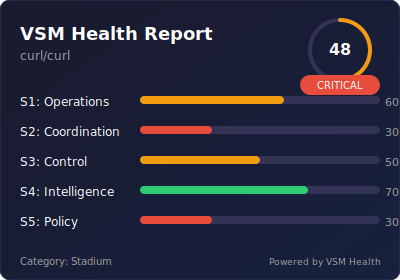


3. Mini Card saved to: docs/badges/curl_curl_mini.svg


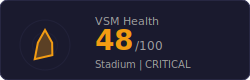

In [17]:
# Generate badges and cards for sample projects
from IPython.display import SVG, display, HTML

# Create output directory for badges
badges_dir = Path('../docs/badges')
badges_dir.mkdir(parents=True, exist_ok=True)

# Generate for curl/curl (Stadium)
if 'curl/curl' in projects:
    curl_report = dashboard.generate_report(projects['curl/curl'])
    
    print("=" * 70)
    print("EMBEDDABLE BADGES FOR curl/curl")
    print("=" * 70)
    
    # Simple badge
    badge_svg = badge_generator.generate_simple_badge(curl_report)
    with open(badges_dir / 'curl_curl_badge.svg', 'w') as f:
        f.write(badge_svg)
    print(f"\n1. Simple Badge saved to: docs/badges/curl_curl_badge.svg")
    display(SVG(badge_svg))
    
    # Detailed card
    card_svg = badge_generator.generate_detailed_card(curl_report, theme='dark')
    with open(badges_dir / 'curl_curl_card.svg', 'w') as f:
        f.write(card_svg)
    print(f"\n2. Detailed Card saved to: docs/badges/curl_curl_card.svg")
    display(SVG(card_svg))
    
    # Mini card
    mini_svg = badge_generator.generate_mini_card(curl_report, theme='dark')
    with open(badges_dir / 'curl_curl_mini.svg', 'w') as f:
        f.write(mini_svg)
    print(f"\n3. Mini Card saved to: docs/badges/curl_curl_mini.svg")
    display(SVG(mini_svg))


EMBEDDABLE BADGES FOR grafana/grafana (Federation)


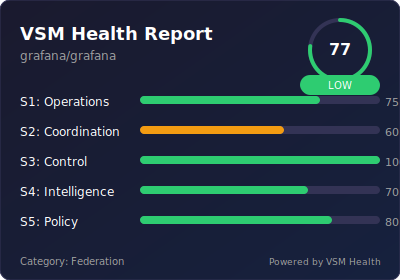


Light theme card:


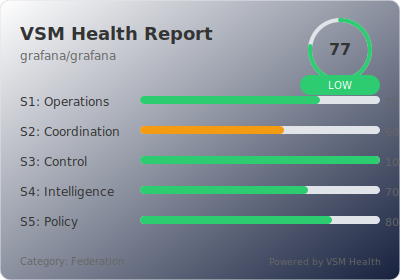

In [18]:
# Generate for grafana/grafana (Federation - healthy project)
if 'grafana/grafana' in projects:
    grafana_report = dashboard.generate_report(projects['grafana/grafana'])
    
    print("\n" + "=" * 70)
    print("EMBEDDABLE BADGES FOR grafana/grafana (Federation)")
    print("=" * 70)
    
    # Save all badge types
    badge_svg = badge_generator.generate_simple_badge(grafana_report)
    with open(badges_dir / 'grafana_grafana_badge.svg', 'w') as f:
        f.write(badge_svg)
    display(SVG(badge_svg))
    
    card_svg = badge_generator.generate_detailed_card(grafana_report, theme='dark')
    with open(badges_dir / 'grafana_grafana_card.svg', 'w') as f:
        f.write(card_svg)
    display(SVG(card_svg))
    
    # Light theme version
    card_light_svg = badge_generator.generate_detailed_card(grafana_report, theme='light')
    with open(badges_dir / 'grafana_grafana_card_light.svg', 'w') as f:
        f.write(card_light_svg)
    print("\nLight theme card:")
    display(SVG(card_light_svg))

In [19]:
# Show README embed instructions
print("\n" + "=" * 70)
print("HOW TO EMBED IN YOUR README")
print("=" * 70)

readme_instructions = '''
## Option 1: Static Badge (self-hosted)

Save the SVG files to your repo and reference them:

```markdown
![VSM Health](./docs/badges/your_project_badge.svg)
```

## Option 2: Dynamic Badge Service (requires deployment)

Deploy the VSM Health API service, then use:

```markdown
<!-- Simple badge -->
![VSM Health](https://vsm-health.your-domain.com/badge/owner/repo)

<!-- Detailed card -->
![VSM Card](https://vsm-health.your-domain.com/card/owner/repo?theme=dark)

<!-- Mini card with radar -->
![VSM Mini](https://vsm-health.your-domain.com/mini/owner/repo?theme=dark)
```

## Option 3: GitHub Actions Integration

Add a workflow to auto-update badges on push:

```yaml
name: Update VSM Badge
on:
  push:
    branches: [main]
  schedule:
    - cron: '0 0 * * 0'  # Weekly

jobs:
  update-badge:
    runs-on: ubuntu-latest
    steps:
      - uses: actions/checkout@v4
      - name: Generate VSM Badge
        run: |
          curl -o docs/badges/vsm_badge.svg \\
            "https://vsm-health.example.com/badge/${{ github.repository }}"
      - name: Commit badge
        run: |
          git config user.name "github-actions[bot]"
          git config user.email "github-actions[bot]@users.noreply.github.com"
          git add docs/badges/
          git diff --staged --quiet || git commit -m "Update VSM health badge"
          git push
```
'''
print(readme_instructions)


HOW TO EMBED IN YOUR README

## Option 1: Static Badge (self-hosted)

Save the SVG files to your repo and reference them:

```markdown
![VSM Health](./docs/badges/your_project_badge.svg)
```

## Option 2: Dynamic Badge Service (requires deployment)

Deploy the VSM Health API service, then use:

```markdown
<!-- Simple badge -->
![VSM Health](https://vsm-health.your-domain.com/badge/owner/repo)

<!-- Detailed card -->
![VSM Card](https://vsm-health.your-domain.com/card/owner/repo?theme=dark)

<!-- Mini card with radar -->
![VSM Mini](https://vsm-health.your-domain.com/mini/owner/repo?theme=dark)
```

## Option 3: GitHub Actions Integration

Add a workflow to auto-update badges on push:

```yaml
name: Update VSM Badge
on:
  push:
    branches: [main]
  schedule:
    - cron: '0 0 * * 0'  # Weekly

jobs:
  update-badge:
    runs-on: ubuntu-latest
    steps:
      - uses: actions/checkout@v4
      - name: Generate VSM Badge
        run: |
          curl -o docs/badges/vsm_badge.svg \
     

In [20]:
# Generate badges for all projects
print("\n" + "=" * 70)
print("GENERATING BADGES FOR ALL PROJECTS")
print("=" * 70)

for repo_name, data in list(projects.items())[:10]:  # First 10 for demo
    try:
        report = dashboard.generate_report(data)
        safe_name = repo_name.replace('/', '_')
        
        # Generate and save badge
        badge_svg = badge_generator.generate_simple_badge(report)
        with open(badges_dir / f'{safe_name}_badge.svg', 'w') as f:
            f.write(badge_svg)
        
        # Generate and save mini card
        mini_svg = badge_generator.generate_mini_card(report)
        with open(badges_dir / f'{safe_name}_mini.svg', 'w') as f:
            f.write(mini_svg)
            
        print(f"  Generated badges for: {repo_name} (Score: {report.overall_score:.0f})")
    except Exception as e:
        print(f"  Error generating badges for {repo_name}: {e}")

print(f"\nBadges saved to: {badges_dir}")


GENERATING BADGES FOR ALL PROJECTS
  Generated badges for: BurntSushi/ripgrep (Score: 34)
  Generated badges for: babel/babel (Score: 53)
  Generated badges for: pandas-dev/pandas (Score: 48)
  Generated badges for: mafintosh/pump (Score: 8)
  Generated badges for: pallets/flask (Score: 35)
  Generated badges for: etcd-io/etcd (Score: 58)
  Generated badges for: vitejs/vite (Score: 56)
  Generated badges for: benjaminp/six (Score: 27)
  Generated badges for: pnggroup/libpng (Score: 44)
  Generated badges for: neovim/neovim (Score: 53)

Badges saved to: ../docs/badges


In [21]:
# Generate reports for all projects
all_reports = {}
for repo_name, data in projects.items():
    all_reports[repo_name] = dashboard.generate_report(data).to_dict()

# Save reports
output_dir = Path('../data/processed')
with open(output_dir / 'vsm_health_reports.json', 'w') as f:
    json.dump(all_reports, f, indent=2, default=str)
print(f"Saved: {output_dir / 'vsm_health_reports.json'}")

# Create summary DataFrame
summary_data = []
for repo_name, report in all_reports.items():
    row = {
        'repository': repo_name,
        'category': report['category'],
        'overall_score': report['overall_score'],
        'risk_level': report['risk_level'],
        'S1_score': report['subsystems']['S1']['score'],
        'S2_score': report['subsystems']['S2']['score'],
        'S3_score': report['subsystems']['S3']['score'],
        'S4_score': report['subsystems']['S4']['score'],
        'S5_score': report['subsystems']['S5']['score'],
    }
    summary_data.append(row)

df_summary = pd.DataFrame(summary_data)
df_summary.to_csv(output_dir / 'vsm_health_summary.csv', index=False)
print(f"Saved: {output_dir / 'vsm_health_summary.csv'}")

print(f"\n{'='*70}")
print("VSM HEALTH SUMMARY BY CATEGORY")
print(f"{'='*70}")
print(df_summary.groupby('category')[['overall_score', 'S1_score', 'S2_score', 'S3_score', 'S4_score', 'S5_score']].mean().round(1))

Saved: ../data/processed/vsm_health_reports.json
Saved: ../data/processed/vsm_health_summary.csv

VSM HEALTH SUMMARY BY CATEGORY
            overall_score  S1_score  S2_score  S3_score  S4_score  S5_score
category                                                                   
club                 46.4      66.1      18.9      57.2      48.4      36.8
federation           49.2      68.3      24.2      65.3      31.1      47.8
stadium              35.3      56.1      17.5      31.9      28.6      35.3
toy                  18.8      28.4      10.3       9.9      10.0      31.1
unknown              50.8      70.0      45.0      62.5      25.0      40.0


In [22]:
# Save CI/CD templates to files
templates_dir = Path('../templates')
templates_dir.mkdir(parents=True, exist_ok=True)

# Workflows
workflows_dir = templates_dir / 'workflows'
workflows_dir.mkdir(exist_ok=True)

for name, content in cicd_generator.templates.items():
    if name not in ['pr_template', 'issue_templates']:
        filepath = workflows_dir / f"{name.replace('_', '-')}.yml"
        with open(filepath, 'w') as f:
            f.write(content)
        print(f"Saved: {filepath}")

# PR template
with open(templates_dir / 'PULL_REQUEST_TEMPLATE.md', 'w') as f:
    f.write(cicd_generator.templates['pr_template'])
print(f"Saved: {templates_dir / 'PULL_REQUEST_TEMPLATE.md'}")

# Issue templates
issue_dir = templates_dir / 'ISSUE_TEMPLATE'
issue_dir.mkdir(exist_ok=True)
for name, content in cicd_generator.templates['issue_templates'].items():
    filepath = issue_dir / f"{name}.yml"
    with open(filepath, 'w') as f:
        f.write(content)
    print(f"Saved: {filepath}")

print("\nAll templates exported!")

Saved: ../templates/workflows/pr-validation.yml
Saved: ../templates/workflows/auto-labeler.yml
Saved: ../templates/workflows/stale-management.yml
Saved: ../templates/workflows/release.yml
Saved: ../templates/PULL_REQUEST_TEMPLATE.md
Saved: ../templates/ISSUE_TEMPLATE/bug_report.yml
Saved: ../templates/ISSUE_TEMPLATE/feature_request.yml

All templates exported!


---
## Summary

This notebook provides three practical tools for OSS maintainers:

### 1. VSM Health Dashboard
- Visual report card with S1-S5 subsystem scores
- Traffic light status indicators (healthy/warning/critical)
- Comparison to category benchmarks
- Priority action list

### 2. Automated S5 Policy Recommendations
- Category-appropriate GOVERNANCE.md templates
- CODE_OF_CONDUCT.md (Contributor Covenant)
- CONTRIBUTING.md guidelines
- MAINTAINERS.md and CODEOWNERS templates

### 3. CI/CD Templates for S2 Improvement
- PR validation workflow (semantic titles, size labels)
- Auto-labeler based on changed files
- Stale issue/PR management
- Release automation
- PR and issue templates

### Usage
```python
# Generate health report
report = dashboard.generate_report(project_data)
visualize_health_dashboard(report)

# Get policy recommendations
policies = policy_engine.generate_recommendations(project_data, report)

# Get CI/CD recommendations
cicd = cicd_generator.generate_recommendations(project_data, report)
```